# 고혈압 분석 모델
## @author: sh22h

- year0_NA를 DataFrame으로 불러오고 4개로 나눔
  - binary: 범주형(binary) 변수, 0 / 1 로 변경
  - categoryH0: 계층 없는 범주형(>3) 변수, one-hot-encoding
  - categoryH1: 계층 있는 범주형 변수, 표준화
  - ctn:연속형 변수, 정규화, 표준화 
  - hyperTension: 고혈압

- 각각 정규화 또는 표준화한 후 변수는 X 고혈압은 y로 둠
  - 정규화(normalization): 0, 1
  - 표준화(standardization): 평균: 0 표준편차: 1
  - 계층화(quantile transform): 4분위 수

## 학습 모델

- 0차
  - 로컬에서 구현

- 1차
  - 2021-07-20
  - normalize_ctn
  - 
  ```
  model = Sequential()
  model.add(Dense(12, input_dim=52, activation='relu'))  # input layer requires input_dim param
  model.add(Dense(15, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
  scores = model.evaluate(X_test, y_test)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
  ```

- 2차
  - 2021-07-26
  - Decision Tree 구현

- 3차
  - 2021-08-02
  - one-hot encoding 구현

- 4차
  - 2021-08-07
  - 전처리 개선
  - Keras Tunor 사용 준비
  - P1 ~ P4 모델 구현

- 5차
  - 2021-08-08
  - 데이터 결측값 관리
    - TOTALC 유의미한 값: 15개
    - 키, 몸무게 결측값 매우 많음
  - 데이터 결측값 제거
    - TOTALC 삭제
    - KNNImputer로 결측값 채우기
    - https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

- 6차
  - 2021-08-12
  - 데이터 결측값 관리
    - 변수 모두 포함하라!
    - 범주형: 최빈값
    - 수치형: 평균값(kNN)
    - TOTALC 포함하라
    - 주말까지
  - DicisionTree 보는 법을 해석하라.
  - 모델 정확도 올리기

- 7차
  - 2021-08-23
  - unit 통일
  - dropout 통일
  - 모델 정확도 여전히 안좋음

- 8차
  - 2021-08-24
  - unit, dropout 다시 분리
  - 레이어 늘림

- 9차
  - 2021-08-26
  - 변수 중요도 낮은 변수 일부 제거하고 모델 돌려보기
    - 영향을 조금이라도 주는 것
      1. 'AS1_AGE'
      2. 'AS1_WEIGHT'
      3. 'AS1_B18'
      4. 'AS1_SEX'
      5. 'P3'
      6. 'AS1_B01'
      7. 'AS1_B04'
    - 나머지, 영향 없음.

- 10차
  - 2021-08-29
  - unit 통일
  - dropout 통일
 
- 11차
  - 2021-08-30
  - max_epoch = 10으로 통일

- 12차
  - 데이터셋 변경

- 13차
  - 2021-09-09
  - 데이터셋 변경
    - P1 ~ P4 -> FA1 ~ FA5 
    - columns 54

- 14차
  - 2021-09-13
  - 데이터 추가
    - AS1_WAIST3_A
    - 허리둘레
    - 계층있는 연속형
    - columns: 55

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 전처리

### 데이터 불러오기

In [2]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/year0_210913.csv', index_col=0, na_values=['NA']) # 허리둘레 추가

idx_dataset = list(dataset.index)
col_dataset = list(dataset.columns)
# dataset.info()

### dataset 결측값 대치

In [3]:
# dataset에 있는 변수 분리
# 범주형, 연속형 등으로 분리하여 raw_var 형태로 저장하여 각각 관리한다.

# 종속변수, 고혈압
HYPERTENSION = dataset['HYPERTENSION']

# 범주형(binary, 0 or 1)
raw_binary = dataset.reindex(columns=['AS1_SEX', 'AS0_TIED', 'AS0_SLPAMSF', 'AS1_STRPHYSJ'])
col_b = raw_binary.columns

#범주형(계층 없음, without hierarchy)
raw_categoryH0 = dataset.reindex(columns=['AS1_JOBB', 'AS1_INSUR'])
col_H0 = raw_categoryH0.columns

# 범주형(계층 있음, with hierarchy)
raw_categoryH1 = dataset.reindex(columns=['AS1_EDUA', 'AS1_INCOME', 'AS1_DRINK', 'AS1_DRDUA',
                                          'AS1_SMOKEA', 'AS1_PHYSTB', 'AS1_PHYSIT', 'AS1_PHYACTL',
                                          'AS1_PHYACTM', 'AS1_PHYACTH', 'AS1_HEALTH'
                                          ])
col_H1 = raw_categoryH1.columns

# 연속형 변수
raw_ctn = dataset.reindex(columns=['AS1_AGE', 'AS1_HVSMAM', 'AS1_HVSMDU', 'AS1_TOTALC',
                                   'AS1_SLPAMTM', 'AS1_RGMEALFQA', 'AS1_HEIGHT', 'AS1_WEIGHT',
                                   'AS1_B01', 'AS1_B02', 'AS1_B03', 'AS1_B04', 'AS1_B05',
                                   'AS1_B06', 'AS1_B07', 'AS1_B08', 'AS1_B09', 'AS1_B10',
                                   'AS1_B11', 'AS1_B12', 'AS1_B13', 'AS1_B14', 'AS1_B15',
                                   'AS1_B16', 'AS1_B17', 'AS1_B18', 'AS1_B19', 'AS1_B20',
                                   'AS1_B21', 'AS1_B23', 'AS1_B24',
                                   'FA1', 'FA2', 'FA3', 'FA4', 'FA5', # 패턴 변경
                                   'AS1_WAIST3_A'
                                   ])
col_c = raw_ctn.columns

In [4]:
print(raw_binary.info(), raw_categoryH0.info(), raw_categoryH1.info(), raw_ctn.info())
print(col_b, col_H0, col_H1, col_c)

<class 'pandas.core.frame.DataFrame'>
Index: 9704 entries, EPI20_026_2_000001 to EPI20_026_2_010030
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AS1_SEX       9704 non-null   int64  
 1   AS0_TIED      9603 non-null   float64
 2   AS0_SLPAMSF   9654 non-null   float64
 3   AS1_STRPHYSJ  9704 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 379.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 9704 entries, EPI20_026_2_000001 to EPI20_026_2_010030
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AS1_JOBB   9698 non-null   float64
 1   AS1_INSUR  9682 non-null   float64
dtypes: float64(2)
memory usage: 227.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 9704 entries, EPI20_026_2_000001 to EPI20_026_2_010030
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   

In [5]:
from sklearn.impute import KNNImputer, SimpleImputer

imp_kNN = KNNImputer(n_neighbors=5)
imp_mean = SimpleImputer(strategy='mean')
imp_mostFreq = SimpleImputer(strategy='most_frequent')

In [6]:
# 최빈값으로 대치
binary = pd.DataFrame(imp_mostFreq.fit_transform(raw_binary),
                      index=idx_dataset, columns=col_b).astype('float') # float형으로 변경.

categoryH0 = pd.DataFrame(imp_mostFreq.fit_transform(raw_categoryH0), 
                          index=idx_dataset, columns=col_H0)
categoryH0 = pd.get_dummies(categoryH0, columns=col_H0).astype('float') # one-hot-encoding

categoryH1 = pd.DataFrame(imp_mostFreq.fit_transform(raw_categoryH1),
                          index=idx_dataset, columns=col_H1)

# kNN, 평균 둘 중 하나만 사용할 예정
ctn = pd.DataFrame(imp_kNN.fit_transform(raw_ctn), index=idx_dataset, columns=col_c)
# ctn = pd.DataFrame(imp_mean.fit_transform(raw_ctn), index=idx_dataset, columns=col_c)


In [7]:
print(binary.info(), categoryH0.info(), categoryH1.info(), ctn.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9704 entries, EPI20_026_2_000001 to EPI20_026_2_010030
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AS1_SEX       9704 non-null   float64
 1   AS0_TIED      9704 non-null   float64
 2   AS0_SLPAMSF   9704 non-null   float64
 3   AS1_STRPHYSJ  9704 non-null   float64
dtypes: float64(4)
memory usage: 379.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 9704 entries, EPI20_026_2_000001 to EPI20_026_2_010030
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AS1_JOBB_0.0   9704 non-null   float64
 1   AS1_JOBB_1.0   9704 non-null   float64
 2   AS1_JOBB_2.0   9704 non-null   float64
 3   AS1_JOBB_3.0   9704 non-null   float64
 4   AS1_JOBB_4.0   9704 non-null   float64
 5   AS1_JOBB_5.0   9704 non-null   float64
 6   AS1_JOBB_6.0   9704 non-null   float64
 7   AS1_JOBB_7.0   9704 non-null   fl

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split

scaler0 = StandardScaler()
scaler1 = MinMaxScaler()
scaler2 = QuantileTransformer()

# category_h1, ctn 정규화
# train만으로 scale 해야하는가? 교수님에게 질문해보기

def standard(categoryH1, ctn):
  categoryH1[col_H1] = scaler0.fit_transform(categoryH1)
  ctn[col_c] = scaler0.fit_transform(ctn)

  return categoryH1, ctn


def minmax(categoryH1, ctn):
  categoryH1[col_H1] = scaler1.fit_transform(categoryH1)
  ctn[col_c] = scaler1.fit_transform(ctn)

  return categoryH1, ctn


def quantile(categoryH1, ctn):
  categoryH1[col_H1] = scaler2.fit_transform(categoryH1)
  ctn[col_c] = scaler2.fit_transform(ctn)

  return categoryH1, ctn

In [9]:
# categoryH1, ctn = standard(categoryH1, ctn)
# categoryH1, ctn = minmax(categoryH1, ctn)
# categoryH1, ctn = quantile(categoryH1, ctn)

### dataset 분리
- train, test

In [10]:
X = pd.concat([binary, categoryH0, categoryH1, ctn], axis=1)
y = dataset['HYPERTENSION']  # 고혈압 변수

# 훈련 데이터 나눔
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=415)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

## 모델 제작

In [ ]:
import IPython
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

!pip install -q -U keras-tuner
import keras_tuner as kt
from keras_tuner import HyperModel

     |████████████████████████████████| 97 kB 4.1 MB/s 


In [ ]:
EPOCH = 128

In [ ]:
# class RegressionHyperModel(HyperModel):
#   def __init__(self, input_shape):
#     self.input_shape = input_shape

def model_builder(hp):
  model = Sequential()
  hp_units = hp.Int('units', min_value = 4, max_value = EPOCH, step = 4)
  hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.05, step=0.05)

  model.add(Dense(units = hp_units, activation='relu')) # input_shape = 63
  
  model.add(Dropout(hp_dropout))
  model.add(Dense(units = hp_units, activation='relu'))
  
  # model.add(Dropout(hp_dropout))
  # model.add(Dense(units = hp_units, activation='relu'))
  
  # model.add(Dropout(hp_dropout))
  # model.add(Dense(units = hp_units, activation='relu'))
  
  # model.add(Dropout(hp_dropout))
  # model.add(Dense(units = hp_units, activation='relu'))

  model.add(Dropout(hp_dropout))
  model.add(Dense(1, activation='sigmoid')) # 출력층

  # Tune the learning rate for the optimizer S
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3]) # 0.01 or 0.001

  model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                loss="binary_crossentropy", # 손실함수: binary_crossentropy
                metrics = ['accuracy']) # 평가지표

  # model.compile(optimizer='rmsprop', 
  #               loss='mse', metrics=['mse']) #손실함수: MSE(mean squared error)
  
  return model

In [ ]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
# input_shape = (X_train.shape[1],)
# hypermodel = RegressionHyperModel(input_shape)

tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = EPOCH,
                     hyperband_iterations = EPOCH,
                     directory = '/content/drive/MyDrive/Colab Notebooks',
                     project_name = 'HyperTension_sh22h_0913_01')

tuner.search(X_train, y_train,
             epochs = EPOCH,
             validation_split=0.2,
             callbacks = [ClearTrainingOutput()])

In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
{best_hps.get('units')}
최적의 학습률은
{best_hps.get('learning_rate')}
최적의 드롭아웃 확률은
{best_hps.get('dropout')}.
""")


//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
100
최적의 학습률은
0.01
최적의 드롭아웃 확률은
0.1.



#### best_hps

- 2021-08-08
  ```
  INFO:tensorflow:Oracle triggered exit
  The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
  72, 8, 104, 32)
   the optimal learning rate for the optimizer is
  0.001
  drop-out is
  (0.03, 0.06).
  ```
  - min_value = 8, max_value = 128, step = 8

- 2021-08-12
  ```
  Best val_accuracy So Far: 0.7678571343421936
  Total elapsed time: 00h 00m 33s
  INFO:tensorflow:Oracle triggered exit
  The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
  (10, 16, 6, 24)
  and the optimal learning rate for the optimizer is
  0.0001
  drop-out is
  (0.044, 0.096).
  ```

  - min_value = 2, max_value = 32, step = 2

- 2021-08-14
  ```
  Best val_accuracy So Far: 0.7726648449897766
  Total elapsed time: 00h 01m 27s
  INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
  (16, 8, 14, 8)
  and the optimal learning rate for the optimizer is
  0.0001
  drop-out is
  (0.085, 0.09).
  ```

  - min_value = 4, max_value = 32, step = 2

- 2021-08-23
  ```
  Trial 16 Complete [00h 00m 21s]
  val_accuracy: 0.7726648449897766

  Best val_accuracy So Far: 0.7743818759918213
  Total elapsed time: 00h 01m 49s
  INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
  28
  and the optimal learning rate for the optimizer is
  0.01
  drop-out is
  0.05.
  ```
- 중요한 변수만 했을때
  - 0.7743818759918213
  - 큰 차이 없음

- 2021-08-29
  ```
  Trial 184 Complete [00h 00m 02s]
  val_accuracy: 0.7779740691184998

  Best val_accuracy So Far: 0.7891637086868286
  Total elapsed time: 00h 22m 51s
  INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete.
  The optimal number of units in the densely-connected layer is
  30
  and the optimal learning rate for the optimizer is
  0.001
  drop-out is
  0.05.
  ```

- 2021-08-30
  ```
  Trial 382 Complete [00h 00m 07s]
  val_accuracy: 0.7623953819274902

  Best val_accuracy So Far: 0.7707662582397461
  Total elapsed time: 00h 27m 33s
  INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete.
  The optimal number of units in the densely-connected layer is
  22
  and the optimal learning rate for the optimizer is
  0.001
  drop-out is
  0.0.
  ```

```
Trial 441 Complete [00h 00m 05s]
val_accuracy: 0.765614926815033

Best val_accuracy So Far: 0.7701223492622375
Total elapsed time: 00h 33m 03s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal number of units in the densely-connected layer is
30
and the optimal learning rate for the optimizer is
0.001
drop-out is
0.05.
```

```
Trial 90 Complete [00h 00m 21s]
val_accuracy: 0.7604635953903198

Best val_accuracy So Far: 0.7617514729499817
Total elapsed time: 00h 07m 40s
INFO:tensorflow:Oracle triggered exit

//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
56
최적의 학습률은
0.01
최적의 드롭아웃 확률은
0.2
```

```
Trial 843 Complete [00h 00m 01s]
val_accuracy: 0.769478440284729

Best val_accuracy So Far: 0.7746297717094421
Total elapsed time: 01h 38m 26s
INFO:tensorflow:Oracle triggered exit

//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
20
최적의 학습률은
0.001
최적의 드롭아웃 확률은
0.1.
```

In [ ]:
model = tuner.hypermodel.build(best_hps)
scores = model.evaluate(X_test, y_test)
print("%s: %.2f, %s: %.2f%%" % (model.metrics_names[0], scores[0], model.metrics_names[1], scores[1] * 100))

61/61 [==============================] - 0s 998us/step - loss: 0.6165 - accuracy: 0.7342
loss: 0.62, accuracy: 73.42%


[Text(0, 0.5, 'loss'), Text(0.5, 0, 'epoch'), Text(0.5, 1.0, 'model loss')]

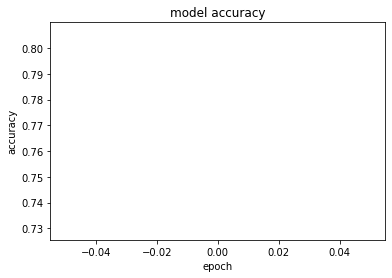

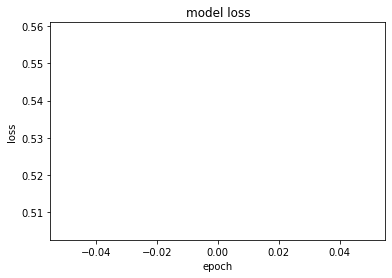

In [ ]:
history = model.fit(X_train, y_train, verbose=0)

fig, ax0 = plt.subplots()
fig, ax1 = plt.subplots()

# 모델의 정확도를 그립니다.
ax0.plot(history.history['accuracy']) 
ax0.set(title='model accuracy', xlabel='epoch', ylabel='accuracy')

# 모델의 오차를 그립니다.
ax1.plot(history.history['loss'])
ax1.set(title='model loss', xlabel='epoch', ylabel='loss')

In [ ]:
history.history

{'accuracy': [0.7677444219589233], 'loss': [0.5317938923835754]}

## Decision Tree

### 하이퍼 파라미터

- min_samples_split
  - 노드를 분할하기 위한 최소한의 샘플 데이터 수로 과적합 제어에 사용.
  - default는 2이다. 작게 설정할수록 분할되는 노드가 많아져 과적합 가능성 증가.
- min_samples_leaf
  - 말단 노드가 되기위한 최소한의 샘플 수
  - 과적합 제어 용도. 비대칭적 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있어 이 경우에는 작게 설정.
- max_features
  - 최적의 분할을 위해 고려할 최대 feature 개수. default는 None으로 데이터 세트의 모든 feature을 사용하여 분할.
  - int로 지정 시 대상 feature 개수, float로 지정 시 전체 feature중 대상 feature의 퍼센트
  - sqrt는 전체 feature중 제곱근 값.
  - auto는 sqrt와 동일
  - log는 전체 featur을 log2()로 선정
- max_depth
  - 트리의 최대 깊이 지정
  - default는 None. 이는 완벽히 클래스 결정값이 될때 까지 깊이를 계속 키우거나 노드가 가지는 데이터 개수가 min_samples_split보다 작아질 때 까지 계속 분할
  - 깊이가 깊어지면 min_samples_split 설정대로 최대 분할하여 과적합할 수 있으므로 적당한 값으로 제어.
- max_leaf_nodes
  - 말단 노드 최대 개수

- 출처: https://velog.io/@lsmmay322/%EA%B2%B0%EC%A0%95%ED%8A%B8%EB%A6%ACDecision-Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

ht_tree = DecisionTreeClassifier(max_depth=5)
ht_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
export_graphviz(ht_tree, out_file="tree.dot",
                class_names='FT',
                feature_names=X.columns,
                impurity=True, filled=True)

In [ ]:
!ls

drive  sample_data  tree.dot


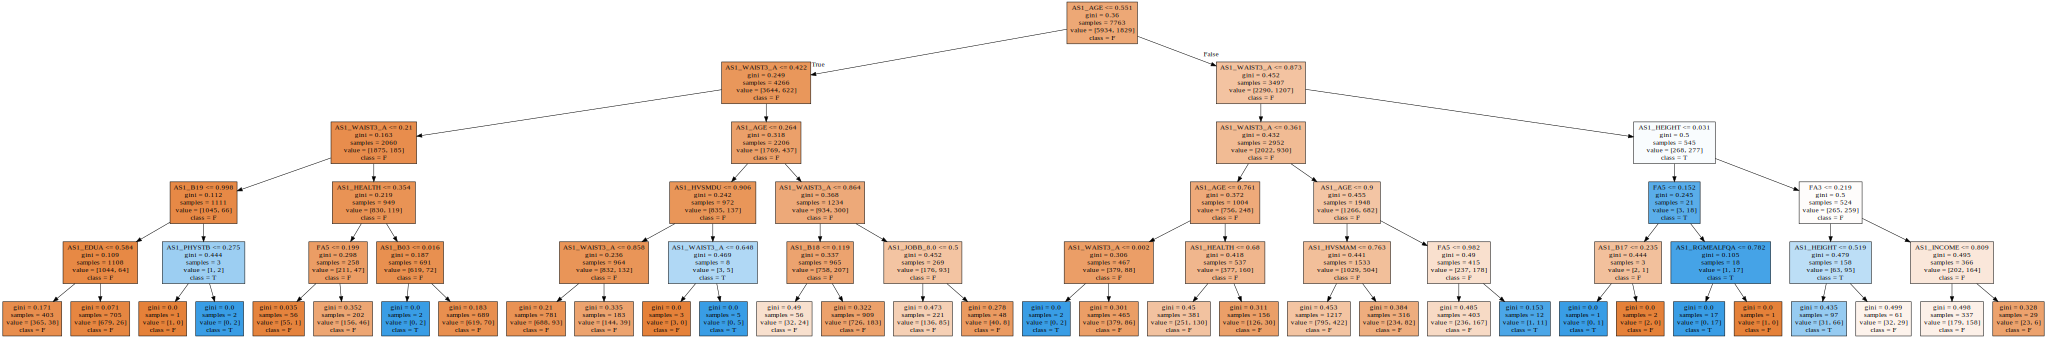

In [ ]:
with open("tree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph, filename='tree.png',format='png')

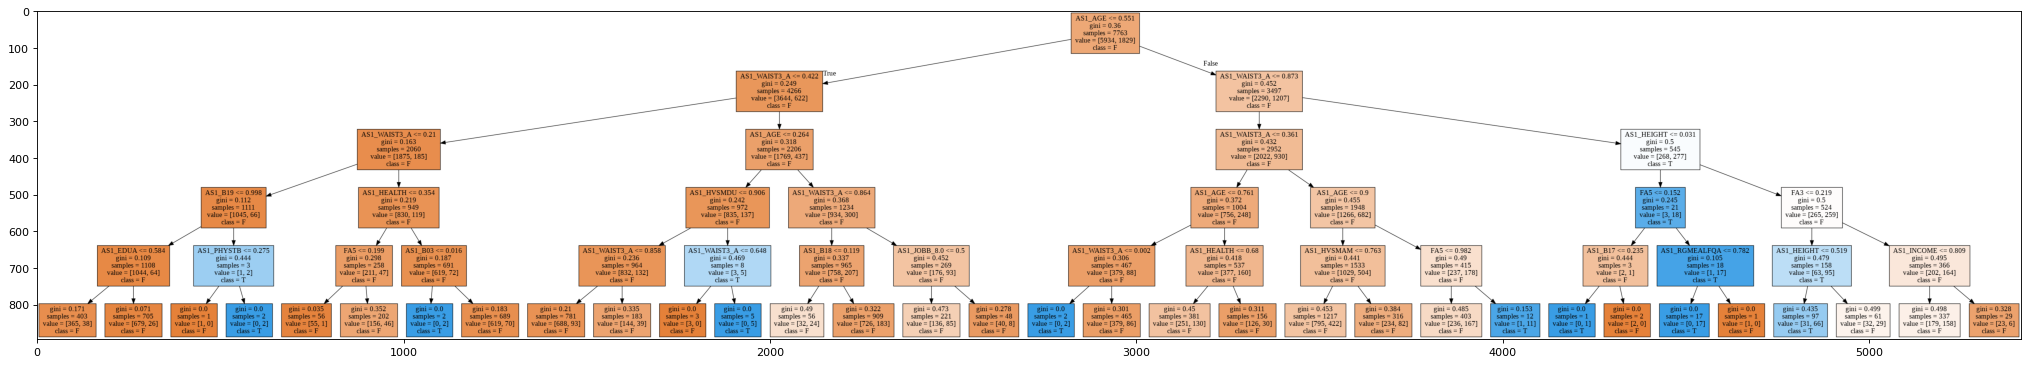

In [ ]:
!dot -Tpng tree.dot -o tree.png

tree_img = plt.imread('./tree.png')

plt.figure(num=None, figsize=(32, 9), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(tree_img)

In [ ]:
print("훈련 세트 정확도: {:.3f}".format(ht_tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(ht_tree.score(X_test, y_test)))

importances = ht_tree.feature_importances_

tree_importances = pd.DataFrame({'feature_importances' : importances}, index=X.columns )
tree_importances.sort_values(by=['feature_importances'], axis=0, inplace=True)

훈련 세트 정확도: 0.774
테스트 세트 정확도: 0.762


Text(0, 0.5, 'feature importance')

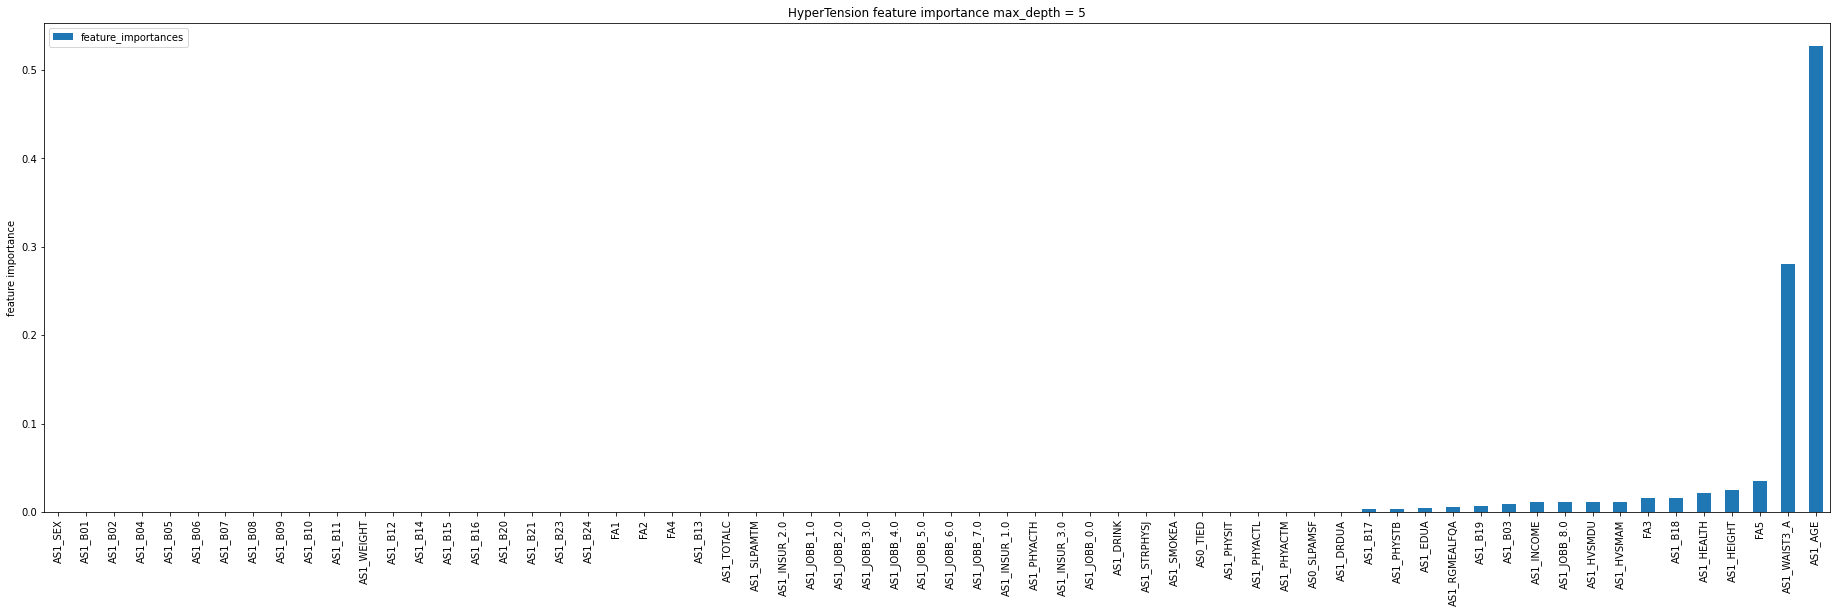

In [ ]:
# 특성 중요도 그래프
fig, ax = plt.subplots(figsize=(32, 9))
tree_importances.plot.bar(ax=ax)
ax.set_title("HyperTension feature importance max_depth = 5")
ax.set_ylabel("feature importance")

### 특성 중요도가 낮은 것 제외하고 모델 제작해보기

- Decision tree로 변수의 특성 중요도 추출,

In [ ]:
tree_importances_0 = tree_importances[tree_importances.feature_importances > 0]
tree_importances_0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, AS1_B17 to AS1_AGE
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   feature_importances  17 non-null     float64
dtypes: float64(1)
memory usage: 272.0+ bytes


In [ ]:
importances_rank = tree_importances.index.to_numpy()

X_cut10 = X[importances_rank[10:]] # 변수 중요도 하위 10개 제거
X_cut20 = X[importances_rank[20:]] # 변수 중요도 하위 20개 제거
X_cut30 = X[importances_rank[30:]]
X_cut40 = X[importances_rank[40:]]
X_cut50 = X[importances_rank[50:]]

X_cut = X[tree_importances_0.index]

In [ ]:
X_cut_train, X_cut_test, y_train, y_test = train_test_split(X_cut, y, test_size=0.2)
print(X_cut_train.shape, X_cut_test.shape, y_train.shape, y_test.shape)

(7763, 17) (1941, 17) (7763,) (1941,)


In [ ]:
cutted_tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = EPOCH,
                     hyperband_iterations = EPOCH,
                     directory = '/content/drive/MyDrive/Colab Notebooks',
                     project_name = 'HyperTension_sh22h_cutted_0913_03')

cutted_tuner.search(X_cut_train, y_train,
                    epochs = EPOCH,
                    validation_split=0.2,
                    callbacks = [ClearTrainingOutput()])

Trial 817 Complete [00h 00m 02s]
val_accuracy: 0.7746297717094421

Best val_accuracy So Far: 0.7817128300666809
Total elapsed time: 02h 15m 44s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
cutted_hps = cutted_tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
{cutted_hps.get('units')}
최적의 학습률은
{cutted_hps.get('learning_rate')}
최적의 드롭아웃 확률은
{cutted_hps.get('dropout')}.
""")


//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
36
최적의 학습률은
0.001
최적의 드롭아웃 확률은
0.15000000000000002.



### 하위 50개 제거 모델

```
Trial 365 Complete [00h 00m 03s]
val_accuracy: 0.769478440284729

Best val_accuracy So Far: 0.7746297717094421
Total elapsed time: 01h 02m 19s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal number of units in the densely-connected layer is
48
and the optimal learning rate for the optimizer is
0.001
drop-out is
0.05.
```

### 상위 18 모델

```
Trial 374 Complete [00h 00m 06s]
val_accuracy: 0.7720540761947632

Best val_accuracy So Far: 0.7759175896644592
Total elapsed time: 01h 08m 56s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal number of units in the densely-connected layer is
60
and the optimal learning rate for the optimizer is
0.001
drop-out is
0.05.
```

### 상위 17 (허리둘레 추가) 모델
```
Trial 809 Complete [00h 00m 03s]
val_accuracy: 0.7733418941497803

Best val_accuracy So Far: 0.7765614986419678
Total elapsed time: 01h 54m 06s
INFO:tensorflow:Oracle triggered exit

//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
104
최적의 학습률은
0.001
최적의 드롭아웃 확률은
0.35000000000000003.
``` 

In [ ]:
model = cutted_tuner.hypermodel.build(cutted_hps)
scores = model.evaluate(X_cut_test, y_test)
print("%s: %.2f, %s: %.2f%%" % (model.metrics_names[0], scores[0], model.metrics_names[1], scores[1] * 100))

61/61 [==============================] - 0s 1ms/step - loss: 0.8015 - accuracy: 0.2494
loss: 0.80, accuracy: 24.94%


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 104)               6760      
_________________________________________________________________
dropout (Dropout)            (None, 104)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               10920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 104)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 105       
Total params: 17,785
Trainable params: 17,785
Non-trainable params: 0
_________________________________________________________________


## 테스트 데이터 분석

In [11]:
X_train.describe()

,AS1_SEX,AS0_TIED,AS0_SLPAMSF,AS1_STRPHYSJ,AS1_JOBB_0.0,AS1_JOBB_1.0,AS1_JOBB_2.0,AS1_JOBB_3.0,AS1_JOBB_4.0,AS1_JOBB_5.0,AS1_JOBB_6.0,AS1_JOBB_7.0,AS1_JOBB_8.0,AS1_INSUR_1.0,AS1_INSUR_2.0,AS1_INSUR_3.0,AS1_EDUA,AS1_INCOME,AS1_DRINK,AS1_DRDUA,AS1_SMOKEA,AS1_PHYSTB,AS1_PHYSIT,AS1_PHYACTL,AS1_PHYACTM,AS1_PHYACTH,AS1_HEALTH,AS1_AGE,AS1_HVSMAM,AS1_HVSMDU,AS1_TOTALC,AS1_SLPAMTM,AS1_RGMEALFQA,AS1_HEIGHT,AS1_WEIGHT,AS1_B01,AS1_B02,AS1_B03,AS1_B04,AS1_B05,AS1_B06,AS1_B07,AS1_B08,AS1_B09,AS1_B10,AS1_B11,AS1_B12,AS1_B13,AS1_B14,AS1_B15,AS1_B16,AS1_B17,AS1_B18,AS1_B19,AS1_B20,AS1_B21,AS1_B23,AS1_B24,FA1,FA2,FA3,FA4,FA5,AS1_WAIST3_A
count,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.00000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000,7763.000000
mean,0.521577,0.595646,0.648718,0.524153,0.003864,0.284040,0.043282,0.266778,0.141955,0.012495,0.055262,0.039031,0.153291,0.007987,0.913178,0.078836,2.34497,3.525828,2.017777,2.130491,0.895144,2.204431,4.974237,4.316244,1.538838,2.193482,2.933660,52.263043,4.507819,6.863481,0.043308,6.745433,2.873837,160.701018,63.295736,1953.769161,66.445962,32.424965,344.148654,478.336854,1025.595904,10.949246,2540.989308,540.311993,3192.613551,1.264460,1.038645,15.661213,128.876852,8.791447,1.792606,247.915368,68.083859,2774.601958,21.735025,7.067628,9.413500,175.428056,47.337370,146.082314,159.587402,46.928121,852.103053,82.516613
std,0.499566,0.490798,0.477402,0.499448,0.062049,0.450985,0.203505,0.442304,0.349027,0.111088,0.228506,0.193682,0.360291,0.089016,0.281592,0.269499,1.28567,1.938688,0.966959,2.272496,1.232486,2.202063,2.565676,2.521656,2.179140,3.193401,0.895092,8.910784,8.994071,12.884139,0.666962,1.386351,0.358357,6.453142,8.442917,694.254571,29.346055,20.588460,117.415905,269.516812,413.893809,5.271158,1199.956351,414.996376,1647.846079,0.614401,0.537969,7.025380,98.479214,4.513619,0.858149,132.087953,63.055427,2427.044226,15.034462,3.501380,5.420369,139.501553,95.530822,310.128678,194.738843,86.945753,308.132622,8.537307
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,40.000000,0.000000,0.000000,0.000000,1.000000,1.000000,132.000000,34.000000,127.000000,7.000000,1.000000,18.000000,18.000000,99.000000,1.000000,193.000000,0.000000,100.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,18.000000,0.000000,3.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.666667
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.00000,2.000000,1.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,2.000000,44.000000,0.000000,0.000000,0.000000,6.000000,3.000000,156.600000,58.000000,1525.000000,48.000000,19.000000,278.000000,294.000000,754.000000,7.000000,1738.500000,287.000000,2077.500000,1.000000,1.000000,11.000000,68.000000,6.000000,1.000000,162.000000,25.000000,1373.000000,12.000000,5.000000,6.000000,80.000000,10.000000,17.000000,18.000000,2.000000,735.000000,76.666667
50%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0000

In [12]:
X_test.describe()

,AS1_SEX,AS0_TIED,AS0_SLPAMSF,AS1_STRPHYSJ,AS1_JOBB_0.0,AS1_JOBB_1.0,AS1_JOBB_2.0,AS1_JOBB_3.0,AS1_JOBB_4.0,AS1_JOBB_5.0,AS1_JOBB_6.0,AS1_JOBB_7.0,AS1_JOBB_8.0,AS1_INSUR_1.0,AS1_INSUR_2.0,AS1_INSUR_3.0,AS1_EDUA,AS1_INCOME,AS1_DRINK,AS1_DRDUA,AS1_SMOKEA,AS1_PHYSTB,AS1_PHYSIT,AS1_PHYACTL,AS1_PHYACTM,AS1_PHYACTH,AS1_HEALTH,AS1_AGE,AS1_HVSMAM,AS1_HVSMDU,AS1_TOTALC,AS1_SLPAMTM,AS1_RGMEALFQA,AS1_HEIGHT,AS1_WEIGHT,AS1_B01,AS1_B02,AS1_B03,AS1_B04,AS1_B05,AS1_B06,AS1_B07,AS1_B08,AS1_B09,AS1_B10,AS1_B11,AS1_B12,AS1_B13,AS1_B14,AS1_B15,AS1_B16,AS1_B17,AS1_B18,AS1_B19,AS1_B20,AS1_B21,AS1_B23,AS1_B24,FA1,FA2,FA3,FA4,FA5,AS1_WAIST3_A
count,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.00000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,0.537867,0.597115,0.665121,0.515198,0.002061,0.285935,0.044822,0.281298,0.138073,0.014426,0.057702,0.040185,0.135497,0.007213,0.915507,0.077280,2.321484,3.543019,1.997424,2.081401,0.859866,2.204019,4.953117,4.295209,1.535806,2.240598,2.958269,52.052035,4.229985,6.566409,0.028645,6.785059,2.874292,160.556208,63.165585,1970.032457,67.230294,33.107676,346.059763,482.253478,1033.963421,11.043792,2575.824833,543.717156,3219.297269,1.297785,1.039670,15.805255,132.483256,8.872746,1.823287,250.038640,70.270479,2779.84544,22.058733,7.114374,9.660999,178.608964,54.801133,158.264297,167.266873,48.386914,849.167439,82.519887
std,0.498693,0.490604,0.472070,0.499898,0.045361,0.451975,0.206967,0.449749,0.345066,0.119268,0.233240,0.196445,0.342342,0.084643,0.278197,0.267104,1.259478,1.962491,0.966711,2.260045,1.209900,2.204168,2.570725,2.508321,2.187212,3.207967,0.908045,8.918929,8.664504,12.583299,0.389824,1.360792,0.350233,6.279280,8.376113,788.544917,34.093111,24.741097,128.708464,287.149389,464.481594,5.718359,1307.814127,418.189119,1742.995347,0.730019,0.593759,7.826876,107.271057,4.933243,0.978740,139.367788,70.944086,2442.54212,15.389635,3.733010,6.656790,160.130166,165.828963,370.347872,207.670970,87.390882,312.015581,8.677886
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,40.000000,0.000000,0.000000,0.000000,2.000000,1.000000,133.000000,35.000000,315.000000,14.000000,3.000000,43.000000,62.000000,217.000000,2.000000,398.000000,27.000000,299.000000,0.000000,0.000000,3.000000,9.000000,1.000000,0.000000,31.000000,0.000000,143.00000,3.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,57.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,2.000000,44.000000,0.000000,0.000000,0.000000,6.000000,3.000000,156.400000,58.000000,1515.000000,47.000000,18.000000,278.000000,289.000000,736.000000,7.000000,1743.000000,286.000000,2085.000000,1.000000,1.000000,11.000000,70.000000,6.000000,1.000000,165.000000,25.000000,1365.00000,12.000000,5.000000,6.000000,79.000000,10.000000,17.000000,17.000000,1.000000,735.000000,76.666667
50%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000

In [ ]:
bins = list(range(40, 71, 10))
bins_label = [str(x)+"대" for x in bins]

count_X_train_AS1_AGE = pd.cut(X_train['AS1_AGE'], bins, right=False, labels=bins_label[:-1])
print(count_X_train_AS1_AGE.value_counts())

count_X_test_AS1_AGE = pd.cut(X_test['AS1_AGE'], bins, right=False, labels=bins_label[:-1])
print(count_X_test_AS1_AGE.value_counts())

40대    3638
60대    2075
50대    2050
Name: AS1_AGE, dtype: int64
40대    950
60대    512
50대    479
Name: AS1_AGE, dtype: int64


In [ ]:
X_train['AS1_SEX'].value_counts()

1.0    4049
0.0    3714
Name: AS1_SEX, dtype: int64

In [ ]:
X_test['AS1_SEX'].value_counts()

1.0    1044
0.0     897
Name: AS1_SEX, dtype: int64

In [ ]:
print(pd.Series(X_train['AS1_JOBB_0.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_JOBB_1.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_JOBB_2.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_JOBB_3.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_JOBB_4.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_JOBB_5.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_JOBB_6.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_JOBB_7.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_JOBB_8.0'] == 0).value_counts())

True     7733
False      30
Name: AS1_JOBB_0.0, dtype: int64
True     5558
False    2205
Name: AS1_JOBB_1.0, dtype: int64
True     7427
False     336
Name: AS1_JOBB_2.0, dtype: int64
True     5692
False    2071
Name: AS1_JOBB_3.0, dtype: int64
True     6661
False    1102
Name: AS1_JOBB_4.0, dtype: int64
True     7666
False      97
Name: AS1_JOBB_5.0, dtype: int64
True     7334
False     429
Name: AS1_JOBB_6.0, dtype: int64
True     7460
False     303
Name: AS1_JOBB_7.0, dtype: int64
True     6573
False    1190
Name: AS1_JOBB_8.0, dtype: int64


In [ ]:
print(pd.Series(X_test['AS1_JOBB_0.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_JOBB_1.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_JOBB_2.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_JOBB_3.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_JOBB_4.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_JOBB_5.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_JOBB_6.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_JOBB_7.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_JOBB_8.0'] == 0).value_counts())

True     1937
False       4
Name: AS1_JOBB_0.0, dtype: int64
True     1386
False     555
Name: AS1_JOBB_1.0, dtype: int64
True     1854
False      87
Name: AS1_JOBB_2.0, dtype: int64
True     1395
False     546
Name: AS1_JOBB_3.0, dtype: int64
True     1673
False     268
Name: AS1_JOBB_4.0, dtype: int64
True     1913
False      28
Name: AS1_JOBB_5.0, dtype: int64
True     1829
False     112
Name: AS1_JOBB_6.0, dtype: int64
True     1863
False      78
Name: AS1_JOBB_7.0, dtype: int64
True     1678
False     263
Name: AS1_JOBB_8.0, dtype: int64


In [ ]:
print(X_train['AS1_EDUA'].value_counts())
print(X_test['AS1_EDUA'].value_counts())

1.0    2633
3.0    2351
2.0    1738
5.0     662
4.0     271
6.0     108
Name: AS1_EDUA, dtype: int64
1.0    651
3.0    579
2.0    464
5.0    152
4.0     70
6.0     25
Name: AS1_EDUA, dtype: int64


In [ ]:
print(X_train['AS1_INCOME'].value_counts())
print(X_test['AS1_INCOME'].value_counts())

1.0    1585
5.0    1367
2.0    1233
3.0    1191
4.0    1062
6.0     758
7.0     420
8.0     147
Name: AS1_INCOME, dtype: int64
1.0    405
5.0    349
2.0    296
3.0    295
4.0    261
6.0    181
7.0    112
8.0     42
Name: AS1_INCOME, dtype: int64


In [ ]:
print(X_train['AS1_DRINK'].value_counts())
print(X_test['AS1_DRINK'].value_counts())

3.0    3699
1.0    3561
2.0     503
Name: AS1_DRINK, dtype: int64
1.0    909
3.0    904
2.0    128
Name: AS1_DRINK, dtype: int64


In [ ]:
print(X_train['AS1_DRDUA'].value_counts())
print(X_test['AS1_DRDUA'].value_counts())

0.0    3692
5.0    2554
4.0     442
1.0     422
2.0     380
3.0     273
Name: AS1_DRDUA, dtype: int64
0.0    937
5.0    612
4.0    123
1.0    112
2.0     95
3.0     62
Name: AS1_DRDUA, dtype: int64


In [ ]:
print(X_train['AS1_SMOKEA'].value_counts())
print(X_test['AS1_SMOKEA'].value_counts())

0.0    4575
3.0    1770
1.0    1197
2.0     221
Name: AS1_SMOKEA, dtype: int64
0.0    1160
3.0     415
1.0     308
2.0      58
Name: AS1_SMOKEA, dtype: int64


In [ ]:
print(X_train['AS1_PHYSTB'].value_counts())
print(X_test['AS1_PHYSTB'].value_counts())

0.0    2406
2.0    1351
1.0    1189
3.0     793
4.0     651
5.0     630
6.0     370
8.0     258
7.0     115
Name: AS1_PHYSTB, dtype: int64
0.0    594
2.0    362
1.0    293
3.0    201
4.0    157
5.0    147
6.0     82
8.0     68
7.0     37
Name: AS1_PHYSTB, dtype: int64


In [ ]:
print(X_train['AS1_PHYSIT'].value_counts().sort_index())
print(X_test['AS1_PHYSIT'].value_counts().sort_index()) 

0.0     435
1.0     452
2.0     792
3.0     752
4.0     716
5.0     998
6.0     977
7.0     521
8.0    2120
Name: AS1_PHYSIT, dtype: int64
0.0    102
1.0    122
2.0    214
3.0    185
4.0    168
5.0    243
6.0    248
7.0    138
8.0    521
Name: AS1_PHYSIT, dtype: int64


In [ ]:
print(X_train['AS1_PHYACTL'].value_counts().sort_index())
print(X_test['AS1_PHYACTL'].value_counts().sort_index())

0.0     379
1.0     697
2.0    1230
3.0    1084
4.0     829
5.0     966
6.0     641
7.0     390
8.0    1547
Name: AS1_PHYACTL, dtype: int64
0.0     85
1.0    172
2.0    325
3.0    287
4.0    213
5.0    215
6.0    168
7.0     89
8.0    387
Name: AS1_PHYACTL, dtype: int64


In [ ]:
print(X_train['AS1_PHYACTM'].value_counts().sort_index())
print(X_test['AS1_PHYACTM'].value_counts().sort_index())

0.0    3925
1.0    1049
2.0     932
3.0     655
4.0     318
5.0     291
6.0     150
7.0     103
8.0     340
Name: AS1_PHYACTM, dtype: int64
0.0    1002
1.0     246
2.0     227
3.0     154
4.0      77
5.0      82
6.0      45
7.0      33
8.0      75
Name: AS1_PHYACTM, dtype: int64


In [ ]:
print(X_train['AS1_PHYACTH'].value_counts().sort_index())
print(X_test['AS1_PHYACTH'].value_counts().sort_index())

0.0    4665
1.0     401
2.0     316
3.0     228
4.0     158
5.0     238
6.0     184
7.0     199
8.0    1374
Name: AS1_PHYACTH, dtype: int64
0.0    1147
1.0      99
2.0      93
3.0      47
4.0      53
5.0      54
6.0      45
7.0      53
8.0     350
Name: AS1_PHYACTH, dtype: int64


In [ ]:
print(pd.Series(X_train['AS1_INSUR_1.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_INSUR_2.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_INSUR_3.0'] == 0).value_counts())

True     7701
False      62
Name: AS1_INSUR_1.0, dtype: int64
False    7089
True      674
Name: AS1_INSUR_2.0, dtype: int64
True     7151
False     612
Name: AS1_INSUR_3.0, dtype: int64


In [ ]:
print(pd.Series(X_test['AS1_INSUR_1.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_INSUR_2.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_INSUR_3.0'] == 0).value_counts())

True     1927
False      14
Name: AS1_INSUR_1.0, dtype: int64
False    1777
True      164
Name: AS1_INSUR_2.0, dtype: int64
True     1791
False     150
Name: AS1_INSUR_3.0, dtype: int64


In [ ]:
print(X_train['AS1_HEALTH'].value_counts().sort_index())
print(X_test['AS1_HEALTH'].value_counts().sort_index())

1.0     314
2.0    2330
3.0    2788
4.0    2219
5.0     112
Name: AS1_HEALTH, dtype: int64
1.0     78
2.0    571
3.0    683
4.0    572
5.0     37
Name: AS1_HEALTH, dtype: int64


In [ ]:
print(X_train['AS0_TIED'].value_counts().sort_index())
print(X_test['AS0_TIED'].value_counts().sort_index())

0.0    3139
1.0    4624
Name: AS0_TIED, dtype: int64
0.0     782
1.0    1159
Name: AS0_TIED, dtype: int64


In [ ]:
print(X_train['AS0_SLPAMSF'].value_counts().sort_index())
print(X_test['AS0_SLPAMSF'].value_counts().sort_index())

0.0    2727
1.0    5036
Name: AS0_SLPAMSF, dtype: int64
0.0     650
1.0    1291
Name: AS0_SLPAMSF, dtype: int64


In [ ]:
print(X_train['AS1_STRPHYSJ'].value_counts().sort_index())
print(X_test['AS1_STRPHYSJ'].value_counts().sort_index())

0.0    3694
1.0    4069
Name: AS1_STRPHYSJ, dtype: int64
0.0     941
1.0    1000
Name: AS1_STRPHYSJ, dtype: int64


In [ ]:
y_train.value_counts()

0    5904
1    1859
Name: HYPERTENSION, dtype: int64

In [ ]:
y_test.value_counts()

0    1511
1     430
Name: HYPERTENSION, dtype: int64